In [2]:
import pyzed.sl as sl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
svo_path = '../data/Schlieren/svo/HD1080_SN35520970_11-03-24.svo'

In [4]:
zed = sl.Camera()

# init parameters
init_params = sl.InitParameters()
init_params.set_from_svo_file(svo_path)
init_params.depth_mode = sl.DEPTH_MODE.ULTRA
init_params.coordinate_units = sl.UNIT.METER
init_params.depth_maximum_distance = 40
init_params.depth_minimum_distance = 1
init_params.sdk_verbose = True

zed.open(init_params)

SUCCESS

In [5]:
calibration_frames = 30
skip_frames = 25

In [6]:
runtime_parameters = sl.RuntimeParameters()
temp_image_left = sl.Mat()
temp_image_right = sl.Mat()

In [7]:
color_array_l = np.zeros((1080, 1920, 3, calibration_frames))
color_array_r = np.zeros((1080, 1920, 3, calibration_frames))

In [8]:
for i in range(calibration_frames * skip_frames):
    zed.grab(runtime_parameters)
    if i % skip_frames != 0:
        continue
    frame_nr = zed.get_svo_position()
    # zed.retrieve_measure(image, sl.MEASURE.DEPTH)
    zed.retrieve_image(temp_image_left, sl.VIEW.LEFT)
    current_frame_l = temp_image_left.get_data()[:, :, :3]
    color_array_l[:, :, :, i // skip_frames] = current_frame_l
    zed.retrieve_image(temp_image_right, sl.VIEW.RIGHT)
    current_frame_r = temp_image_right.get_data()[:, :, :3]
    color_array_r[:, :, :, i // skip_frames] = current_frame_r

In [9]:
# get median depth
median_depth_l = np.nanmedian(color_array_l, axis=3)
median_depth_r = np.nanmedian(color_array_r, axis=3)

In [10]:
print(median_depth_l.shape)
print(median_depth_r.shape)

(1080, 1920, 3)
(1080, 1920, 3)


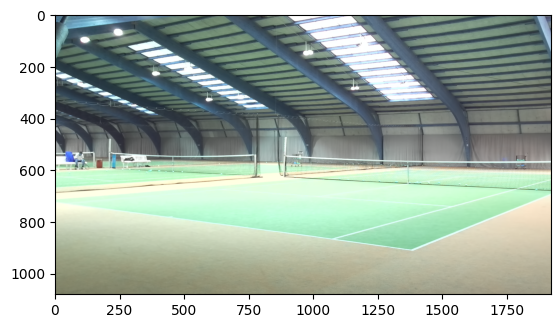

In [11]:
plt.imshow(median_depth_l.astype(np.uint8))

In [12]:
image_left = sl.Mat()
image_right = sl.Mat()

In [13]:
for i in range(10):
    zed.grab(runtime_parameters)
zed.retrieve_image(image_left, sl.VIEW.LEFT)
zed.retrieve_image(image_right, sl.VIEW.RIGHT)
current_frame_left = image_left.get_data()[:, :, :3]
current_frame_right = image_right.get_data()[:, :, :3]

In [14]:
moving_left = current_frame_left - median_depth_l
moving_right = current_frame_right - median_depth_r

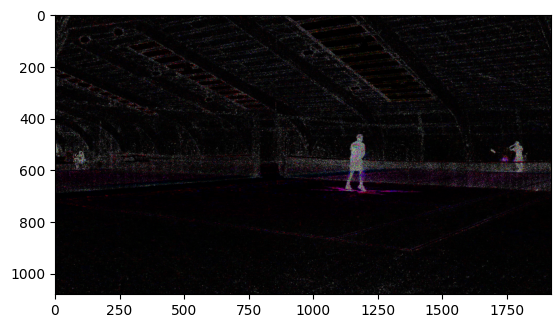

In [15]:
plt.imshow(np.square(moving_left.astype(np.uint8)))

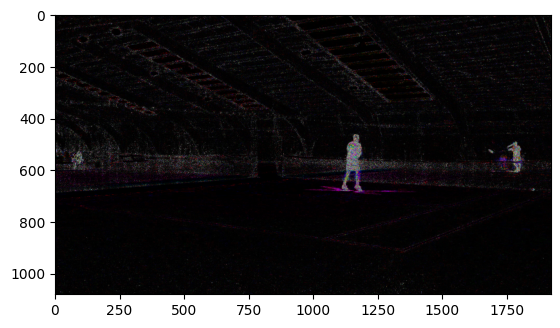

In [16]:
plt.imshow(np.square(moving_right.astype(np.uint8)))

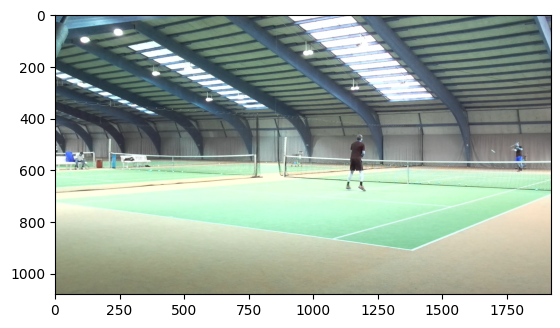

In [17]:
plt.imshow(current_frame_left.astype(np.uint8))

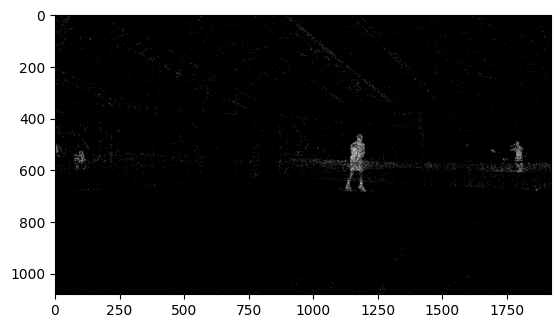

In [18]:
diff_left = np.square(moving_left.astype(np.uint8)).sum(axis=2)
plt.imshow((diff_left / diff_left.max()).round(), cmap='gray')

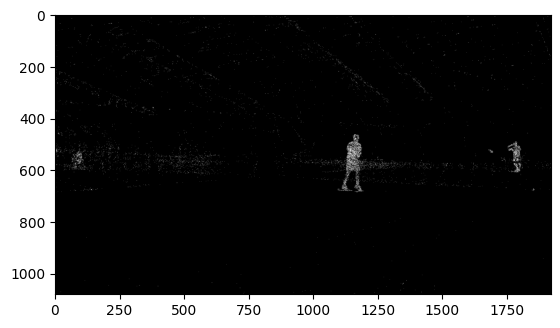

In [19]:
diff_right = np.square(moving_right.astype(np.uint8)).sum(axis=2)
plt.imshow((diff_right / diff_right.max()).round(), cmap='gray')

In [20]:
temp_image = (diff_right / diff_right.max()).round()

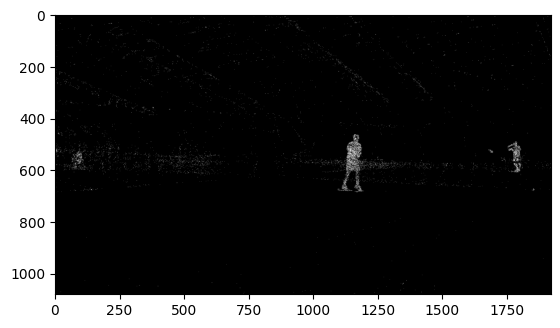

In [22]:
plt.imshow(temp_image, cmap='gray')

In [103]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

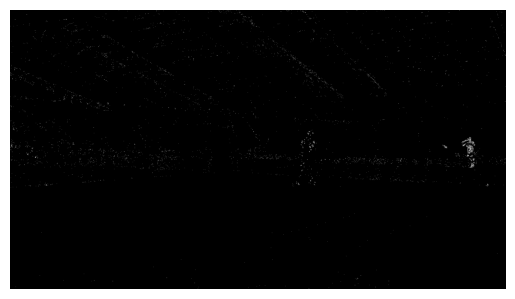

In [113]:
image = (temp_image * 255).astype(np.uint8)

blurred = cv2.GaussianBlur(image, (5, 5), 0)

# Detect circles
circles = cv2.HoughCircles(
   blurred,
   cv2.HOUGH_GRADIENT,
   dp=1,
   minDist=20,
   param1=50,
   param2=10,
   minRadius=10,
   maxRadius=200
)

if circles is not None:
   circles = np.uint16(np.around(circles))
   
   for circle in circles[0, :]:
       x, y, r = circle
       # Draw the circle
       cv2.circle(image, (x, y), r, (0, 255, 0), 4)  # You can change the color and thickness
       # Draw the center of the circle
       cv2.circle(image, (x, y), 2, (0, 0, 255), 3)  # You can change the color and thickness

# Display the result
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()